# {TITLE}

{Author} and the HERA Validation Team

<h3 id="tocheading">Table of Contents</h3>
<div id="toc"></div>

{We recommend installing jupyter_contrib_nbextensions and enabling the Table of Contents(2) extension, at which point this section can be removed, as it will be generated automatically.  The simplest way of doing this is ``conda install -c conda-forge jupyter_contrib_nbextensions``. To enable the extension, either go to ``localhost:xxxx/nbextensions`` and switch it on, or use ``jupyter nbextension enable toc2/main``. You'll also need to switch on the option to "Add a Table of Contents cell at the top of the notebook". Then delet this and the following javascript cell. 

If you don't want to install this, then leave the heading and javascript here, and execute the JS cell right before submitting the notebook.
}

In [10]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Setup and Metadata

### Abstract

{Brief abstract with high-level discussion of goals.}

### Imports

In [1]:
%matplotlib inline
import copy
import glob
import os
import re

import astropy
from astropy import constants, units
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RectBivariateSpline
from datetime import datetime

import hera_sim
import hera_cal
import hera_pspec
import pyuvdata
from pyuvdata import UVCal, UVData, UVFlag
import uvtools
from uvtools.dspec import gen_window
from uvtools.plot import waterfall
from uvtools.utils import FFT, fourier_freqs

if hera_sim.version.version.startswith('0'):
    from hera_sim.rfi import _listify
else:
    from hera_sim.utils import _listify

/users/rpascua/hera_packages/hera_sim/hera_sim/__init__.py:35: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, changes will be made such that the Simulator class is the most intuitive way of interfacing with the hera_sim package features.
  FutureWarning)


### Description

In [2]:
print("Last executed: %s"%str(datetime.now()))

Last executed: 2020-03-11 12:36:01.531750


{If you installed the ``jupyter_contrib_nbextensions``, then enable the "Python Markdown" extension, remove the line above, and keep the following line. Otherwise, remove the following line and keep the line above.}

Last executed: {str(datetime.now())}

- **Major Step Description:** {Insert standard description of major step}
- **Minor Variation Description:** {Insert standard description of minor step}
- **Pipelines Tested:** {Brief list of explicit pipelines tested in the notebook}
- **Criteria**:
  1. {Explicit Criterion for success 1}
  2. {Explicit Criterion for success 2}
  

### Summary

The results of this validation test, in reference to the outlined criteria, are
1. {Test results for criteria 1}
2. {Test results for criteria 2...}

{Brief notes on anything else interesting that was noted during testing}

### Software

HERA software used in this validation test, with associate git commit hash:

* {``pyuvdata``: `a8f6b6fdd7261`}
* {If you have the Python Markdown extension, you can do this: ``pyuvdata``: ``{pyuvdata.version.git_hash}``
* {``hera_qm``: `f3e32c3cef36cbd`}
* {etc.}

Versions of other software used in this validation test:

* {``numpy``: vx.x.x}
* {etc. (only list imported modules).}

### Data

The following paths reflect the exact locations of all data used in this test:

In [3]:
# rfi flags
flag_filepath = "/lustre/aoc/projects/hera/jburba/hera-validation/test-series/3/flags.uvh5"
lst_binned_flag_filepath = flag_filepath.replace("flags", "lst_binned_flags")
idr2_filepath = "/lustre/aoc/projects/hera/H1C_IDR2/IDR2_2/2458101"
smoothcal_files = sorted(
    glob.glob(os.path.join(idr2_filepath, "*.smooth_abs.calfits"))
)

# path to visibility files; these are just symlinks to the ones used for 1.2.0
vis_data_path = "/lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities"
foreground_vis_files = sorted(
    glob.glob(os.path.join(vis_data_path, "zen.*.foregrounds.uvh5"))
)
eor_vis_files = sorted(
    glob.glob(os.path.join(vis_data_path, "zen.*.eor.uvh5"))
)
true_vis_files = sorted(
    glob.glob(os.path.join(vis_data_path, "zen.*.true.uvh5"))
)

### Convenience Functions

In [83]:
def plot_waterfalls(data, freqs, times, windows=None, mode='log', 
                    cmap='inferno', dynamic_range=None, limit_drng='all',
                    baseline=None, horizon_color='magenta', plot_limits=None,
                    freq_window_kwargs=None, time_window_kwargs=None):
    # do some data prep
    freq_window_kwargs = freq_window_kwargs or {}
    time_window_kwargs = time_window_kwargs or {}
    if windows is not None:
        if len(_listify(windows)) > 2:
            raise ValueError("Only up to two windows may be specified.")
        if len(_listify(windows)) == 2:
            time_window = gen_window(windows[0], times.size, **time_window_kwargs)
            freq_window = gen_window(windows[1], freqs.size, **freq_window_kwargs)
        else:
            if not isinstance(windows, str):
                windows = windows[0]
            time_window = gen_window(windows, times.size, **time_window_kwargs)
            freq_window = gen_window(windows, freqs.size, **freq_window_kwargs)
    else:
        time_window = gen_window(None, times.size, **time_window_kwargs)
        freq_window = gen_window(None, freqs.size, **freq_window_kwargs)
        
    time_window = time_window[:, None]
    freq_window = freq_window[None, :]
    data_fr = FFT(data * time_window, axis=0)
    data_dly = FFT(data * freq_window, axis=1)
    data_fr_dly = FFT(FFT(data * time_window, axis=0) * freq_window, axis=1)
    
    fringe_rates = fourier_freqs(times * units.day.to('s')) * 1e3 # mHz
    dlys = fourier_freqs(freqs) * 1e9 # ns
    plot_freqs = freqs / 1e6
    jd = int(np.floor(times[0]))
    plot_times = times - jd
    
    if baseline is not None:
        horizon = np.linalg.norm(baseline) / constants.c.value * 1e9
        
    fig = plt.figure(figsize=(14,10))
    axes = fig.subplots(2,2)
    for j, ax in enumerate(axes.ravel()):
        column = j % 2
        row = j // 2
        xlabel = "Frequency [MHz]" if row == 0 else "Delay [ns]"
        ylabel = "Time Since JD%d [days]" % jd if column == 0 else "Fringe Rate [mHz]"
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        
        xlimits, ylimits = None, None
        if column == 0 and row == 0:
            use_data = data
            extent = (
                plot_freqs.min(), plot_freqs.max(), plot_times.max(), plot_times.min()
            )
            vis_label = r"$\log_{10}|V(\nu, t)|$ [Jy]"
            if plot_limits is not None:
                xlimits = plot_limits.get("freq", extent[:2])
                ylimits = plot_limits.get("time", extent[2:])
        elif column == 0 and row == 1:
            use_data = data_dly
            extent = (dlys.min(), dlys.max(), plot_times.max(), plot_times.min())
            vis_label = r"$\log_{10}|\tilde{V}(\tau, t)|$ [Jy Hz]"
            if plot_limits is not None:
                xlimits = plot_limits.get("delay", extent[:2])
                ylimits = plot_limits.get("time", extent[2:])
        elif column == 1 and row == 0:
            use_data = data_fr
            extent = (
                plot_freqs.min(), plot_freqs.max(), fringe_rates.max(), fringe_rates.min()
            )
            vis_label = r"$\log_{10}|\tilde{V}(\nu, f)|$ [Jy s]"
            if plot_limits is not None:
                xlimits = plot_limits.get("freq", extent[:2])
                ylimits = plot_limits.get("fringe_rate", extent[2:])
        else:
            use_data = data_fr_dly
            extent = (dlys.min(), dlys.max(), fringe_rates.max(), fringe_rates.min())
            vis_label = r"$\log_{10}|\tilde{V}(\tau, f)|$ [Jy Hz s]"
            if plot_limits is not None:
                xlimits = plot_limits.get("delay", extent[:2])
                ylimits = plot_limits.get("fringe_rate", extent[2:])
            
        xlimits = xlimits or extent[:2]
        ylimits = ylimits or extent[2:]
        
        if dynamic_range is not None and mode == 'log':
            vmax = np.log10(np.abs(use_data)).max()
            vmin = vmax * 10**-dynamic_range
        else:
            vmin, vmax = None, None
            
        clip_drng = False
        if limit_drng == 'all':
            limit_drng = ("freq", "time", "delay", "fringe_rate")
        if "time" in limit_drng:
            if column == 0:
                clip_drng = True
        if "freq" in limit_drng:
            if row == 0:
                clip_drng = True
        if "delay" in limit_drng:
            if row == 1:
                clip_drng = True
        if "fringe_rate" in limit_drng:
            if column == 1:
                clip_drng = True
                
        if not clip_drng:
            vmin, vmax = None, None
            
        cbar_label = vis_label if mode == 'log' else "Phase [rad]"
        fig.sca(ax)
        cax = waterfall(
            use_data, extent=extent, mode=mode, vmin=vmin, vmax=vmax, cmap=cmap
        )
        ax.set_xlim(xlimits)
        ax.set_ylim(ylimits)
        if baseline is not None and row == 1:
            ax.axvline(horizon, color=horizon_color, ls='--')
            ax.axvline(-horizon, color=horizon_color, ls='--')
        
        _ = fig.colorbar(cax, label=cbar_label)
        
    return fig

## Flag Preparation

Suggested method of flag preparation, determined via discussion with Josh:
1. Choose one of the days of data from the IDR2_2 directory on lustre (avoiding 2458104, 2458105, and 2458109)
2. Use the smoothed abscal solutions to retrieve the flags for that day
3. Apply a logical AND over all antennas' flag arrays
4. Figure out how to broadcast the resulting flag array to the simulated data

In [9]:
# method 1: take LST-binned flags and broadcast
uvf = UVFlag(lst_binned_flag_filepath)
flags = uvf.flag_array[:,0,:,0]
flag_lsts = np.unique(uvf.lst_array)
flag_freqs = uvf.freq_array.flatten()
flag_spline_v1 = RectBivariateSpline(flag_lsts, flag_freqs, flags, kx=1, ky=1)

In [8]:
# method 2: load flags from a day of data from IDR2.2
cal_smoother = hera_cal.smooth_cal.CalibrationSmoother(smoothcal_files)

In [31]:
uvd = UVData()
uvd.read_uvh5(true_vis_files[0], read_data=False)
# just want the telescope location from this
hera_location = uvd.telescope_location_lat_lon_alt_degrees

# also find out all the lsts
pattern = re.compile("[0-9]{7}.[0-9]{5}")
jds = np.asarray(
    [float(pattern.findall(fname)[0]) for fname in true_vis_files]
)
file_lsts = pyuvdata.utils.get_lst_for_time(jds, *hera_location)

Telescope RIMEz calculation is not in known_telescopes.


In [33]:
def wrap_lsts(lsts):
    return (lsts + np.pi) % (2 * np.pi) - np.pi

In [58]:
use_files = []
neg_lsts = []
for vis_file, file_lst in zip(true_vis_files, file_lsts):
    if flag_lsts.min() <= wrap_lsts(file_lst) <= flag_lsts.max():
        if wrap_lsts(file_lst) < 0:
            continue
            neg_lsts.append(vis_file)
        else:
            use_files.append(vis_file)
use_files = neg_lsts + use_files

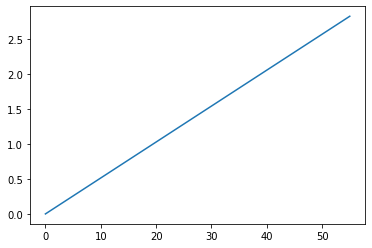

In [59]:
use_jds = np.asarray(
    [float(pattern.findall(fname)[0]) for fname in use_files]
)
use_lsts = pyuvdata.utils.get_lst_for_time(use_jds, *hera_location)
plt.plot(wrap_lsts(use_lsts))

In [12]:
flag_times = np.hstack(tuple([times_ for times_ in cal_smoother.cal_times.values()]))
flag_freqs = list(cal_smoother.cal_freqs.values())[0]
flag_lsts = pyuvdata.utils.get_lst_for_time(
    flag_times, *uvd.telescope_location_lat_lon_alt_degrees
)
flag_lsts = wrap_lsts(flag_lsts)
flags = np.ones((flag_times.size, flag_freqs.size), dtype=bool)
for flags_ in cal_smoother.flag_grids.values():
    flags = np.logical_and(flags, flags_)
flag_spline_v2 = RectBivariateSpline(flag_lsts, flag_freqs, flags.astype(float), kx=1, ky=1)

In [61]:
uvd = UVData()
uvd.read_uvh5(use_files)

Telescope RIMEz calculation is not in known_telescopes.


In [62]:
lsts = np.unique(uvd.lst_array)
freqs = uvd.freq_array.flatten()
use_flags_v1 = flag_spline_v1(lsts, freqs).astype(np.bool)
use_flags_v2 = flag_spline_v2(lsts, freqs).astype(np.bool)

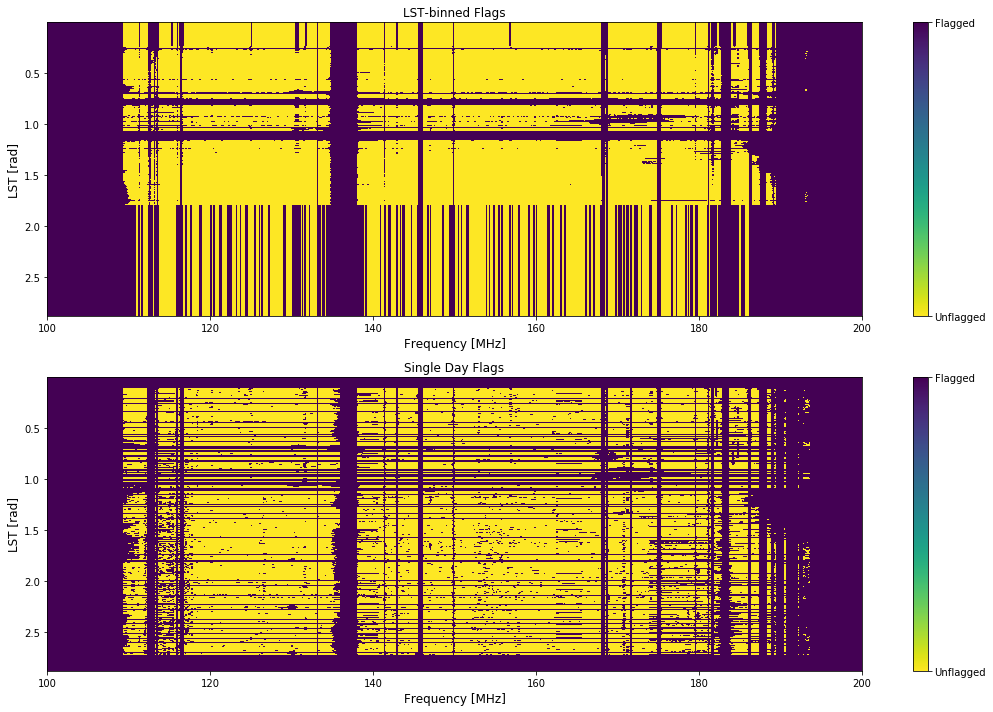

In [69]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.set_title("LST-binned Flags", fontsize=12)
ax2.set_title("Single Day Flags", fontsize=12)
for ax in (ax1, ax2):
    ax.set_xlabel("Frequency [MHz]", fontsize=12)
    ax.set_ylabel("LST [rad]", fontsize=12)
cmap = "viridis_r"
extent = (freqs.min() / 1e6, freqs.max() / 1e6, lsts.max(), lsts.min())
cax1 = ax1.imshow(use_flags_v1.astype(float), aspect='auto', extent=extent, cmap=cmap)
cax2 = ax2.imshow(use_flags_v2.astype(float), aspect='auto', extent=extent, cmap=cmap)
for ax, cax in zip((ax1, ax2), (cax1, cax2)):
    fig.sca(ax)
    cbar = fig.colorbar(cax)
    cbar.set_ticks((0,1))
    cbar.set_ticklabels(("Unflagged", "Flagged"))
    
fig.tight_layout()

## Simulating Crosstalk and Cable Reflections

In [96]:
# extract the autocorrelation
baselines = np.unique(uvd.baseline_array)
baselines = [uvd.baseline_to_antnums(bl) for bl in baselines]
autobl = [bl for bl in baselines if bl[0] == bl[1]][0]
pol = 'xx'
autokey = autobl + (pol,)
autovis = uvd.get_data(autokey)

# get some metadata
freqs = uvd.freq_array.flatten()
times = np.unique(uvd.time_array)
lsts = np.unique(uvd.lst_array)
antpos, ants = uvd.get_ENU_antpos()

These systematics are simulated using tools available in `hera_sim.sigchain`. In particular, we will use the `gen_cross_coupling_xtalk` and `gen_reflection_gains` functions from that module. The parameters chosen to characterize the crosstalk and cable reflections (and subsequently remove these systematics) will be motivated and informed by the following sources: 
* http://reionization.org/wp-content/uploads/2013/03/HERA064_reflection_memo.pdf (reflections) 
* https://arxiv.org/pdf/1909.11732.pdf (systematics paper; theory)
* https://arxiv.org/pdf/1909.11733.pdf (systematics paper; data)
* https://github.com/HERA-Team/H1C_IDR2/blob/master/notebooks/validation/xtalk_removal.ipynb
    * (crosstalk removal, we'll use the SVD-based approach with GPR smoothing)
* https://github.com/HERA-Team/H1C_IDR2/blob/master/pipeline/prms_preprocess.yaml
    * (reference for choosing parameter values for pre-pspec, post-analysis processing)
* https://docs.google.com/presentation/d/1LYd9fn-5mkY4u0KtOzbnDo1nJQRQekQuuibuVawk9bw/edit#slide=id.p
    * (pspec pipeline flowchart)

In [98]:
# choose a baseline
cross_bl = (0,0)
while cross_bl[0] == cross_bl[1]:
    cross_bl = baselines[np.random.randint(len(baselines))]
crosskey = cross_bl + (pol,)
crosscorr_vis = uvd.get_data(crosskey)

# now choose some parameters for making the crosstalk
# Nick's justification: this gives something that looks realistic
Ncopies = 10
xamps = np.logspace(-4.0, -6.0, Ncopies)
xdlys = np.linspace(900, 1300, Ncopies) # ns
xphs = np.random.random(Ncopies) * 2 * np.pi

# write a function for generating crosstalk
def gen_xtalk(uvd, autovis, xamps, xdlys, xphs=None):
    if xphs is None:
        xphs = np.random.random(len(xamps)) * 2 * np.pi
    xtalk = np.zeros((uvd.Ntimes, uvd.Nfreqs), dtype=uvd.data_array.dtype)
    gen_xtalk_ = hera_sim.sigchain.gen_cross_coupling_xtalk
    freqs = uvd.freq_array.flatten() / 1e9
    for amp, dly, phs in zip(xamps, xdlys, xphs):
        xtalk += gen_xtalk_(freqs, autovis, amp, dly, phs)
        xtalk += gen_xtalk_(freqs, autovis, amp, -dly, phs)
        
    return xtalk
        
xtalk_vis = gen_xtalk(uvd, autovis, xamps, xdlys, xphs)

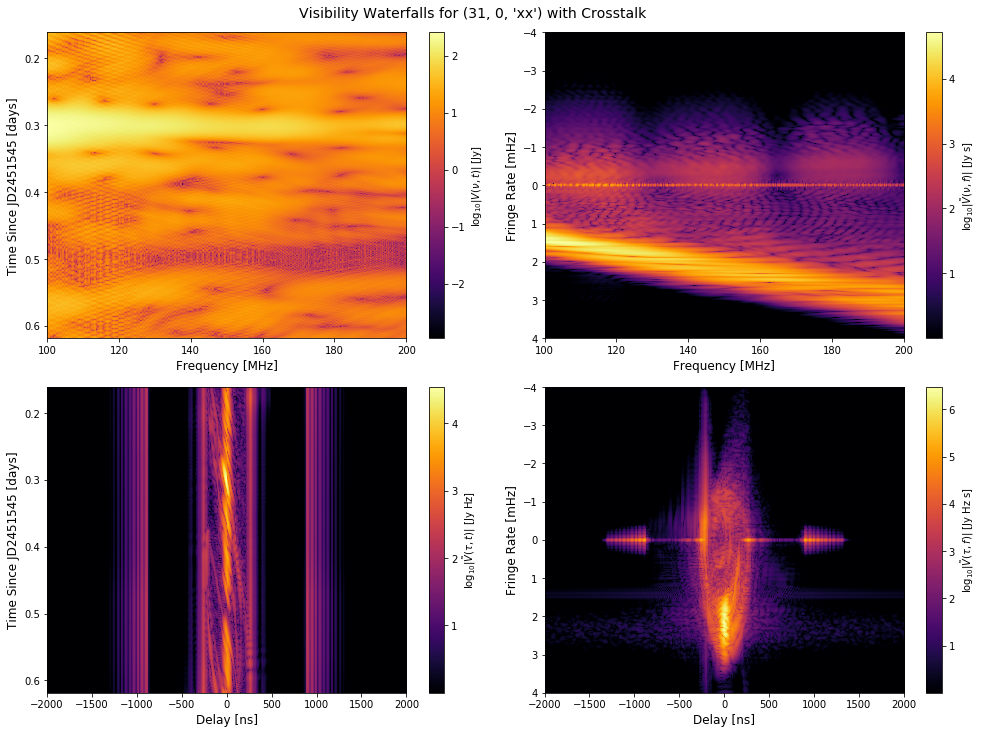

In [99]:
time_taper = 'blackman-harris'
freq_taper = 'blackman-harris'
baseline = antpos[list(ants).index(crosskey[0])] - antpos[list(ants).index(crosskey[1])]
plot_limits = {"delay" : (-2000, 2000), "fringe_rate" : (4, -4)}
fig = plot_waterfalls(
    xtalk_vis + crosscorr_vis, freqs, times, windows=(time_taper, freq_taper),
    dynamic_range=5, limit_drng=("delay", "fringe_rate"),
    baseline=None, horizon_color="dodgerblue", cmap='inferno',
    plot_limits=plot_limits
#    mode='phs', cmap='twilight'
)
title = "Visibility Waterfalls for %s with Crosstalk" % str(crosskey)
fig.text(0.3, 1, title, fontsize=14)
fig.tight_layout()
save_path = "/users/rpascua/plots/fg_plus_eor_plus_xtalk.pdf"
fig.savefig(save_path)
fig.savefig(save_path.replace(".pdf", ".png"))

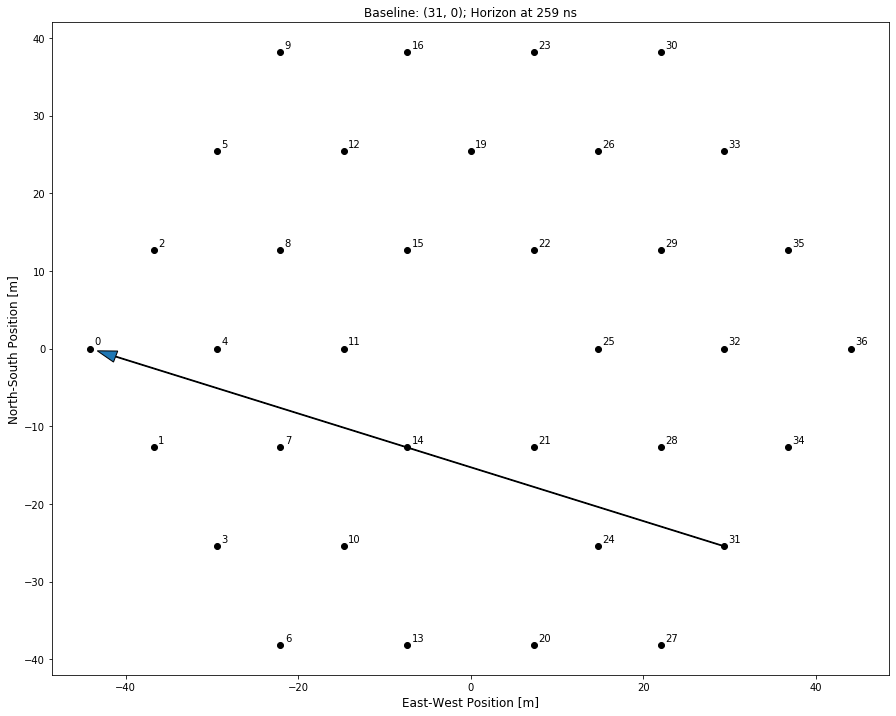

In [100]:
ds = 0.5

fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111)
ax.set_xlabel("East-West Position [m]", fontsize=12)
ax.set_ylabel("North-South Position [m]", fontsize=12)
for ant, pos in zip(ants, antpos):
    x, y, z = pos
    ax.plot(x, y, marker='o', color='k')
    ax.text(x + ds, y + ds, ant)
xi, yi, zi = antpos[list(ants).index(crosskey[0])]
xj, yj, zj = antpos[list(ants).index(crosskey[1])]
dx = xj - xi
dy = yj - yi
dz = zj - zi
horizon = np.sqrt(dx**2 + dy**2 + dz**2) / constants.c.value * 1e9
tail_width = 0.1
head_width = tail_width * 15
f = 0.96
_ = ax.arrow(xi, yi, f * dx, f * dy, width=tail_width, head_width=head_width)
_ = ax.set_title(
    "Baseline: %s; Horizon at %d ns" % (str(crosskey[:2]), horizon), fontsize=12
)

In [101]:
# experiment with cable reflections
# first, let's just do it with an autocorrelation
Nants = len(ants)
rdlys = np.random.uniform(1100, 1300, Nants)
rphs = np.random.uniform(0, 2*np.pi, Nants)
ramps = 10**np.random.uniform(-3, -2, Nants)
refl_gains = hera_sim.sigchain.gen_reflection_gains(
    freqs / 1e9, ants, ramps, rdlys, rphs
)

def gen_reflections(ants, freqs, rdlys, amp_min=1/35, amp_max=1/25):
    refl_gains = {ant : np.ones(freqs.size, dtype=np.complex) for ant in ants}
    for dly in rdlys:
        if amp_max / amp_min > 0.1:
            amps = [np.random.uniform(amp_min, amp_max) for ant in ants]
        else:
            amps = [
                10**np.random.uniform(np.log10(amp_min), np.log10(amp_max)) for ant in ants
            ]
        phs = [np.random.random() * 2 * np.pi for ant in ants]
        dlys = [dly for ant in ants]
        refl_gain = hera_sim.sigchain.gen_reflection_gains(
            freqs, ants, amps, dlys, phs
        )
        for ant, gain in refl_gain.items():
            refl_gains[ant] += gain - 1
            
    return refl_gains

#refl_gains = gen_reflections(
#    [autobl[0]], freqs / 1e9, rdlys, amp_min=1e-3, amp_max=1e-2
#)
autovis_with_refl = hera_sim.sigchain.apply_gains(autovis, refl_gains, autobl)

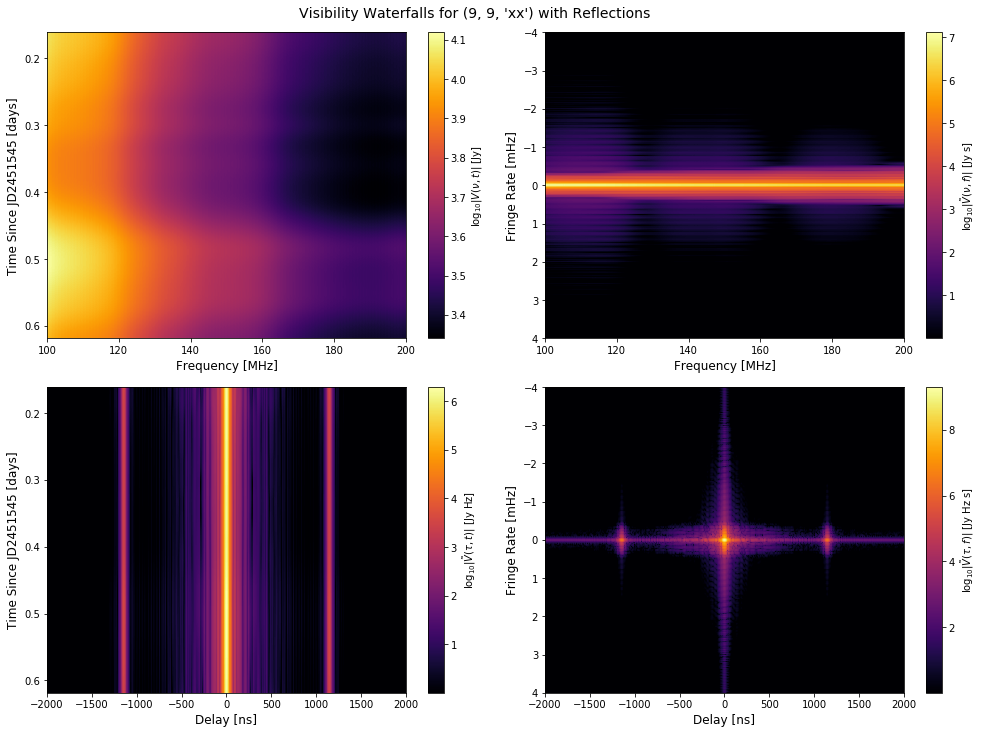

In [102]:
time_taper = 'blackman-harris'
freq_taper = 'blackman-harris'

fig = plot_waterfalls(
    autovis_with_refl, freqs, times, windows=(time_taper, freq_taper),
    dynamic_range=5, limit_drng=("delay", "fringe_rate"),
    plot_limits=plot_limits
#    mode='phs', cmap='twilight'
)
title = "Visibility Waterfalls for %s with Reflections" % str(autokey)
fig.text(0.3, 1, title, fontsize=14)
fig.tight_layout()

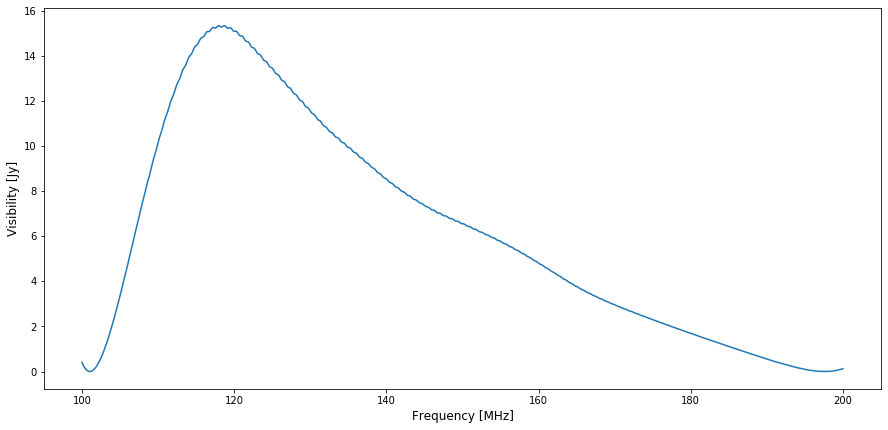

In [76]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.set_xlabel("Frequency [MHz]", fontsize=12)
ax.set_ylabel("Visibility [Jy]", fontsize=12)
gain = hera_sim.sigchain.gen_gains(freqs / 1e9, [0])[0]
bandpass = np.abs(gain)**2
#bandpass = 1
_ = ax.plot(freqs / 1e6, np.abs(autovis_with_refl).mean(axis=0) * bandpass)

In [103]:
cross_vis = uvd.get_data(crosskey)
cross_vis = hera_sim.sigchain.apply_gains(cross_vis, refl_gains, crosskey[:2])
cross_vis += xtalk_vis

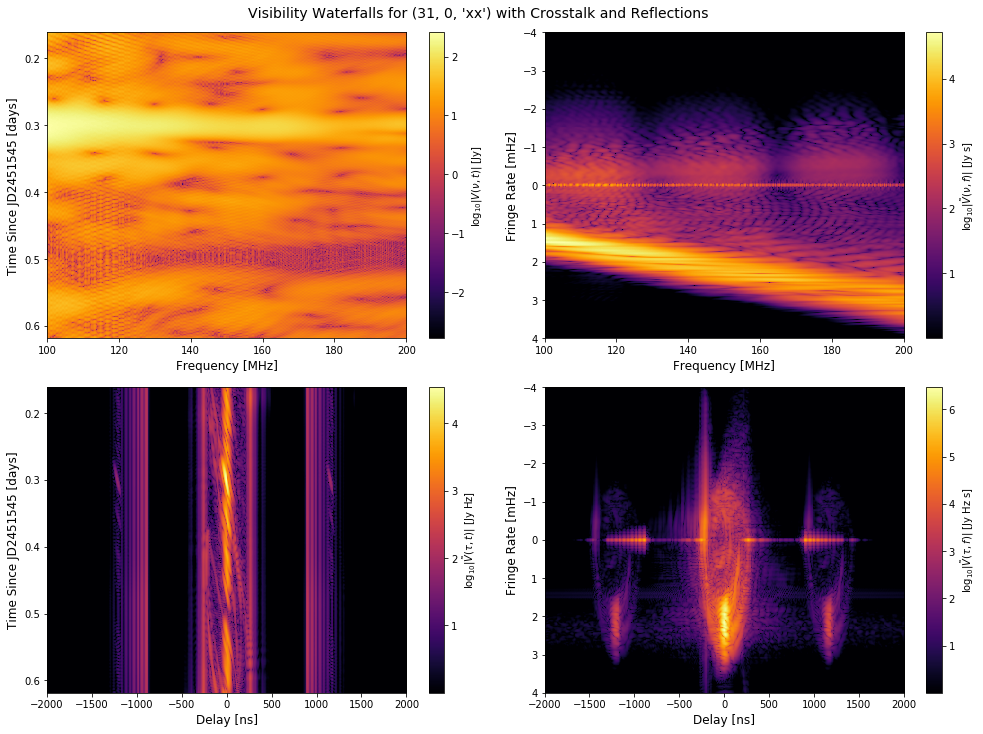

In [104]:
time_taper = 'blackman-harris'
freq_taper = 'blackman-harris'
baseline = antpos[list(ants).index(crosskey[0])] - antpos[list(ants).index(crosskey[1])]
plot_limits = {"delay" : (-2000, 2000), "fringe_rate" : (4, -4)}

fig = plot_waterfalls(
    cross_vis, freqs, times, windows=(time_taper, freq_taper),
    dynamic_range=5, limit_drng=("delay", "fringe_rate"),
    baseline=None, horizon_color="dodgerblue", cmap='inferno',
    plot_limits=plot_limits,
#    mode='phs', cmap='twilight'
)
title = "Visibility Waterfalls for %s with Crosstalk and Reflections" % str(crosskey)
fig.text(0.25, 1, title, fontsize=14)
fig.tight_layout()
save_path = "/users/rpascua/plots/fg_plus_eor_plus_xtalk_with_refl.pdf"
fig.savefig(save_path)
fig.savefig(save_path.replace(".pdf", ".png"))

In [107]:
# simulate xtalk/reflections/gains for the whole array
# simple implementation: use a single xtalk visibility for the whole array
uvd_uncal = copy.deepcopy(uvd)
bandpass_gains = hera_sim.sigchain.gen_gains(freqs / 1e9, ants)
use_pols = ('xx', 'yy')
for baseline in baselines:
    for pol in use_pols:
        key = baseline + (pol,)
        blt_inds, conj_blt_inds, pol_inds = uvd._key2inds(key)
        data = uvd_uncal.get_data(key)
        data = hera_sim.sigchain.apply_gains(data, refl_gains, antpair)
        xtalk_vis = gen_xtalk(uvd, autovis, xamps, xdlys)
        data += xtalk_vis
        data = hera_sim.sigchain.apply_gains(data, bandpass_gains, antpair)
        uvd_uncal.data_array[blt_inds, 0, :, pol_inds[0]] = data
        if len(conj_blt_inds) != 0:
            uvd_uncal.data_array[conj_blt_inds, 0, :, pol_inds[1]] = data.conj()

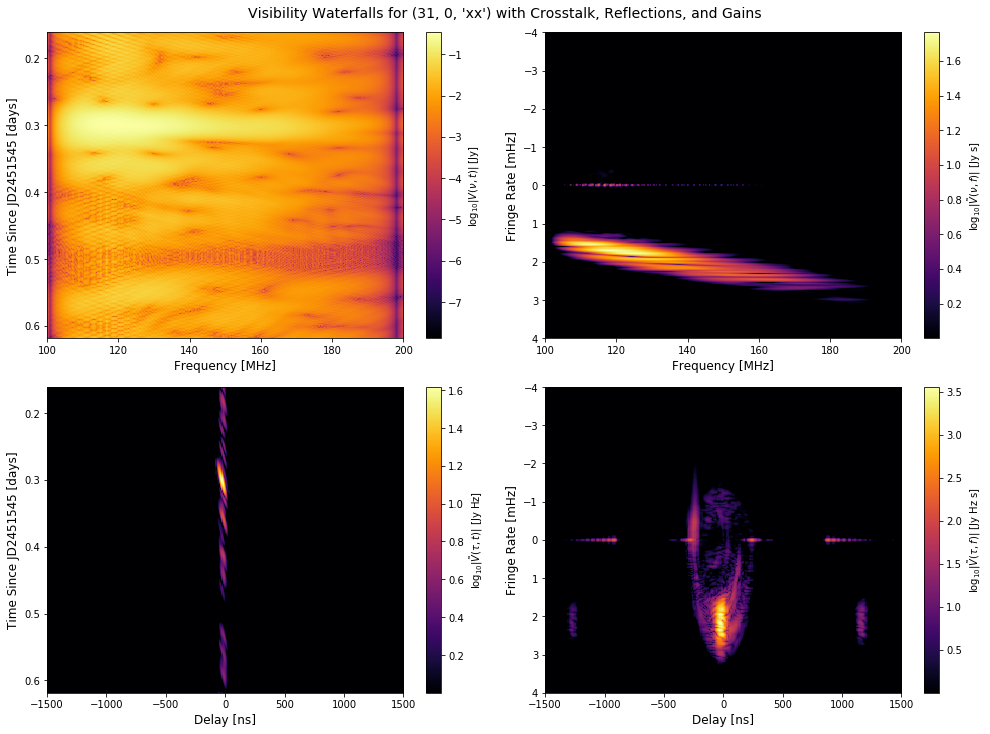

In [109]:
# let's check it out
time_taper = 'blackman-harris'
freq_taper = 'blackman-harris'
baseline = antpos[list(ants).index(crosskey[0])] - antpos[list(ants).index(crosskey[1])]
plot_limits = {"delay" : (-1500, 1500), "fringe_rate" : (4, -4)}
plot_vis = uvd_uncal.get_data(crosskey)
freq_window_kwargs = {"edgecut_low" : 50, "edgecut_high" : 50}

fig = plot_waterfalls(
    plot_vis, freqs, times, windows=(time_taper, freq_taper),
    dynamic_range=5, limit_drng=("delay", "fringe_rate"),
    baseline=None, horizon_color="dodgerblue", cmap='inferno',
    plot_limits=plot_limits, freq_window_kwargs=freq_window_kwargs
#    mode='phs', cmap='twilight'
)
title = "Visibility Waterfalls for %s with Crosstalk, Reflections, and Gains" % str(crosskey)
fig.text(0.25, 1, title, fontsize=14)
fig.tight_layout()
save_path = "/users/rpascua/plots/fg_plus_eor_all_systematics.pdf"
fig.savefig(save_path)
fig.savefig(save_path.replace(".pdf", ".png"))

## Simulating Bandpass Gains

Bandpass gains will be simulated using `hera_sim.sigchain.gen_gains`, in the same manner as was done for the Step 2.0.0 and Step 2.1.0 tests. We will use the H1C bandpass model.

## Data Preparation

Include a brief discussion here about how the raw simulation data was prepared; point to the files in `/lustre/aoc/projects/hera/Validation/test-1.2.0/` used for data preparation. Perhaps show the progression of systematics addition (can make a function for this that makes 4 waterfalls for each pair of frequency/time and their Fourier duals). Point to the scripts that perform the preparation done above for an entire day, for the fully inflated array. 
 
Outline of preparation steps: 
* Combine visibility components to make a true visibility (already done)
* Simulate and apply crosstalk and cable reflections
* Uncalibrate the data with simulated gains
* Do not apply RFI flags until post-abscal

## Data Analysis: Calibration, Systematics Removal, Inpainting with CLEAN

Refer to the analysis flowchart: https://github.com/HERA-Team/hera_opm/blob/master/pipelines/h1c/idr2/v2/Analysis_Flowchart.pdf 

Since we're just using flags (and not simulating RFI with this test), it seems like we should perhaps do the following: 
* Run redcal on the uncalibrated data
* Do post_redcal_abscal_run on the results of the above
* Apply RFI flags to the abscal solutions
* Run smoothcal on the flagged abscal solutions
* Update smoothcal solutions to remove cable reflections
    * ~**in the currrent pipeline, cable reflections are just sort of left alone and don't seem to be removed&mdash;so do we remove them in this test?**~
    * Currently, cable reflections are removed as one of the final steps in the preproc pipe
* Update the omnical visibilities and zero out data where there are RFI flags
* Perform delay CLEANing on the modified visibilities
* Perform crosstalk removal on the CLEANed visibilities
* Push the result through `pspec`
 
Questions:
* Are we ever going to do any foreground filtering in these validation tests?
* If RFI doesn't actually exist in the data, but RFI flags are applied at some point, then does it make sense to corrupt the antenna gains and run redcal/abscal/smoothcal?

Order of operations in preprocessing pipeline:
1. Apply RFI Flags to visibilities

## Power Spectrum Retrieval

Standard use of `hera_pspec`, see step 2.1.0 test for reference.

## Extension to Full Day

Take all of the above and write scripts to prepare data, as well as a makeflow for data analysis.  
**Somewhat serious concern:** I am running out of space on Lustre, and I do not want to take up extra space if it is unnecessary; I would like to have a discussion with folks about getting rid of some data (I will also need a buffer of up to ~500 GB in order to run my RFI stuff for testing).

In [116]:
hera_cal.vis_clean.VisClean.vis_clean??